In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pjr import *
import string
from timeit import default_timer as timer
from pprint import pprint


pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getZAMP (fspec, vname, levs):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    #lat1 = fspec['lat']
    #lon1 = fspec['lon']
    #lev1 = fspec['lev']

    #Fxav = cdutil.averager(F,axis="x")
    #print "Txav=", Txav.info()

    ps = fspec('PS',squeeze=1)
    hyam = fspec('hyam',squeeze=1)
    hybm = fspec('hybm',squeeze=1)

    start = timer()
    P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
    P = P/100.; P.units = "hPa"
    stop1 = timer()
    print  "reconstruct P time = ", stop1-start
    FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
    stop2 = timer()
    print "interp time", stop2-stop1

    #print "FP1.info", FP1.info()
    FP1xav = cdutil.averager(FP1,axis="x")
    return FP1xav;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TP0 = T0.pressureRegrid(nlevs) # vertical regrid
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
    # vertical regridding seems to lose the mask so add one back in
    list = (TP0 > 0.9*TP0.missing_value) 
    TP0.mask = list # make sure the missing vales are masked
    TP0xav = cdutil.averager(TP0,axis="x")
    levsp0 = TP0xav.getAxis(0)
    lat0 = TP0xav.getAxis(1)

    TP1xav = getZAMP (g1, vname, levs)
    levsp1 = TP1xav.getAxis(0)
    lat1 = TP1xav.getAxis(1)

    TP2xav = getZAMP (g2, vname, levs)
    levsp2 = TP2xav.getAxis(0)
    lat2 = TP2xav.getAxis(1)

    DT2xav = TP2xav - TP0xav
    DT1xav = TP1xav - TP0xav

    return TP0xav, DT1xav, DT2xav;

def pltdat (TP0xav, DT1xav, DT2xav):

    fig = plt.figure(figsize=(5., 10.), facecolor='white')
    axest = fig.add_subplot(311)
    axesm = fig.add_subplot(312)
    axesb = fig.add_subplot(313)

    dlevs = findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
    print "diff contour levs", dlevs

    cmap = plt.cm.viridis_r
    plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':TP0xav.long_name,'rtitle':ltit0,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest)
    cmap = diverge_map()
    plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
    plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
    plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

    # show plot
    #plt.show()
    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

            

In [3]:
#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# identify the levels that we will interpolate to
levs = findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to

# the season to plot
seas = "ANN"
seas = "DJF"

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
ltit0 = "MERRA2"
print "jname0", jname0

# model1 dataset
dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1

# model2 dataset
dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2  

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("Relative Humidity", "RELHUM","hur"))
vlist.append(vsets("Temperature", "T", "ta"))
vlist.append(vsets("Zonal Wind", "U", "ua"))


levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_DJF_1980_2016_climo.nc
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_DJF_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_DJF_climo.nc


i Relative Humidity


/global/project/projectdirs/acme/software/anaconda_envs/cori/base/envs/e3sm_unified_1.2.4_py2.7_nox/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/global/project/projectdirs/acme/software/anaconda_envs/cori/base/envs/e3sm_unified_1.2.4_py2.7_nox/lib/python2.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


reconstruct P time =  0.192962884903
interp time 22.2429511547
reconstruct P time =  0.590564012527
interp time 53.9046151638
ZAVG_Relative Humidity_DJF_MERRAvsModels.pdf
diff contour levs [-35. -30. -25. -20. -15. -10.  -5.   5.  10.  15.  20.  25.  30.  35.]
i Temperature
reconstruct P time =  0.186017036438
interp time 22.046877861
reconstruct P time =  0.663333177567
interp time 52.9687988758
ZAVG_Temperature_DJF_MERRAvsModels.pdf
diff contour levs [-14. -12. -10.  -8.  -6.  -4.  -2.   2.   4.   6.   8.  10.  12.  14.]
i Zonal Wind
reconstruct P time =  0.170613050461
interp time 22.9707820415
reconstruct P time =  0.835960149765
interp time 52.9243998528
ZAVG_Zonal Wind_DJF_MERRAvsModels.pdf
diff contour levs [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   2.   4.   6.   8.
  10.  12.  14.  16.  18.  20.]


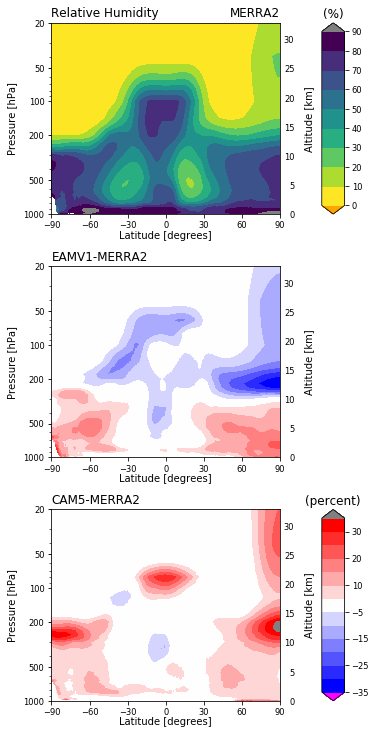

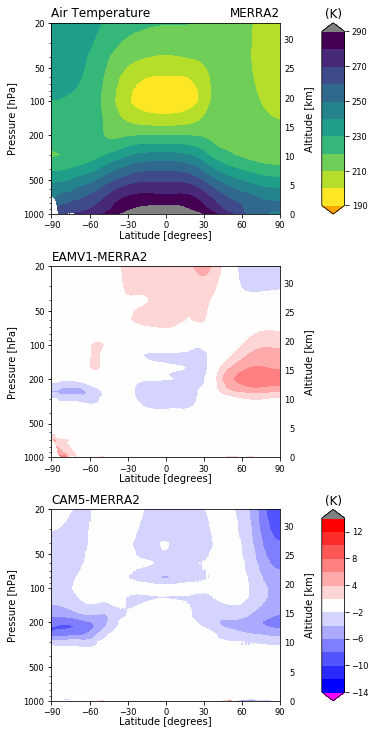

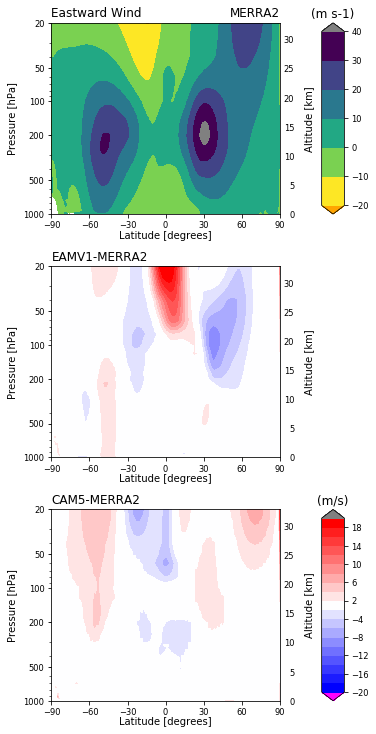

In [4]:
#------------------------------------------
# open the files and make the plots

g0 = cdms2.open(jname0);
varlist = g0.listvariables();
dims = g0.listdimension();
g1 = cdms2.open(jname1);
g2 = cdms2.open(jname2)

for i in vlist:
    print "i", i.name
    pltname = "ZAVG_"+i.name+"_"+seas+"_MERRAvsModels.pdf"
    TP0xav, DT1xav, DT2xav = getdat(g0, i.oname, g1, g2, i.mname)
    print pltname
    pltdat(TP0xav, DT1xav, DT2xav)
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    #break